In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [ ]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [ ]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [ ]:
# SFZ - Solicitacao inscricao
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_sol_ic_prefix.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_sol_ic_prefix.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_sol_ic_prefix.csv')

In [ ]:
df_train.columns

Index(['CaseID', 'Activity', 'Duration', 'Timestamp', 'Duration Float',
       'Time to conclusion', 'Passed Time', 'Step', 'Prefix', 'Activity Cat'],
      dtype='object')

In [ ]:
#df_train = df_train.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_val = df_val.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_test = df_test.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})

In [ ]:
df_train = df_train[df_train['Time to conclusion'] != 0]
df_val = df_val[df_val['Time to conclusion'] != 0]
df_test = df_test[df_test['Time to conclusion'] != 0]

In [ ]:
print(df_train['Time to conclusion'].std(),
df_val['Time to conclusion'].std(),
df_test['Time to conclusion'].std())

42.31159172979721 23.211399557156334 24.97866947016909


In [ ]:
#len(df_test['Case ID'].unique())

In [ ]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

In [ ]:
df_test['Step'].max()

21

### Features extraction

In [ ]:
from keras.preprocessing.text import Tokenizer

### Features selection

In [ ]:
MAX_LEN = max(max(df_train['Step']),max(df_val['Step']),max(df_test['Step']))

In [ ]:
df_prefix_train = df_train['Prefix'].str.split(',', expand = True)
col = df_prefix_train.shape[1]
for i in range(MAX_LEN - df_prefix_train.shape[1]):
    df_prefix_train.insert(df_prefix_train.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_val = df_val['Prefix'].str.split(',', expand = True)
col = df_prefix_val.shape[1]
for i in range(MAX_LEN - df_prefix_val.shape[1]):
    df_prefix_val.insert(df_prefix_val.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_test = df_test['Prefix'].str.split(',', expand = True)
col = df_prefix_test.shape[1]
for i in range(MAX_LEN - df_prefix_test.shape[1]):
    df_prefix_test.insert(df_prefix_test.shape[1], col+i, None)
    #print(i)

In [ ]:
df_prefix_train = df_prefix_train.fillna('')
df_prefix_val = df_prefix_val.fillna('')
df_prefix_test = df_prefix_test.fillna('')

In [ ]:
tokenize_mode = 'sequences_to_matrix'

In [ ]:
kerasTokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=",")


train_txt = df_train['Activity'].values
val_txt = df_val['Activity'].values
test_txt = df_test['Activity'].values

kerasTokenizer.fit_on_texts(train_txt)

train_sequences = kerasTokenizer.texts_to_sequences(train_txt)
val_sequences = kerasTokenizer.texts_to_sequences(val_txt)
test_sequences = kerasTokenizer.texts_to_sequences(test_txt)

train_matrix = kerasTokenizer.texts_to_matrix(train_txt, mode='binary')
val_matrix = kerasTokenizer.texts_to_matrix(val_txt, mode='binary')
test_matrix = kerasTokenizer.texts_to_matrix(test_txt, mode='binary')


train_sequences_matrix = kerasTokenizer.sequences_to_matrix(train_sequences, mode='binary')
val_sequences_matrix = kerasTokenizer.sequences_to_matrix(val_sequences, mode='binary')
test_sequences_matrix = kerasTokenizer.sequences_to_matrix(test_sequences, mode='binary')

Text to sequences

In [ ]:
df_train_sequences = pd.DataFrame(train_sequences).fillna(0).astype(int)
col = df_train_sequences.shape[1]
for i in range(MAX_LEN - df_train_sequences.shape[1]):
    df_train_sequences.insert(df_train_sequences.shape[1], col+i, 0)
    #print(i)


df_test_sequences = pd.DataFrame(test_sequences).fillna(0).astype(int)
col = df_test_sequences.shape[1]
for i in range(MAX_LEN - df_test_sequences.shape[1]):
    df_test_sequences.insert(df_test_sequences.shape[1], col+i, 0)
    #print(i)

df_val_sequences = pd.DataFrame(val_sequences).fillna(0).astype(int)
col = df_val_sequences.shape[1]
for i in range(MAX_LEN - df_val_sequences.shape[1]):
    df_val_sequences.insert(df_val_sequences.shape[1], col+i, 0)
    #print(i)


In [ ]:
if(tokenize_mode == 'sequences_to_matrix'):
    X_train = np.concatenate((df_train[['Step', 'Duration Float', 'Passed Time']].values,
                              train_sequences_matrix), axis=1)
    y_train = df_train[['Time to conclusion']].values

    X_test = np.concatenate((df_test[['Step', 'Duration Float', 'Passed Time']].values,
                             test_sequences_matrix), axis=1)
    y_test = df_test[['Time to conclusion']].values


    X_val = np.concatenate((df_val[['Step', 'Duration Float', 'Passed Time']].values,
                            val_sequences_matrix), axis=1)
    y_val = df_val[['Time to conclusion']].values

In [ ]:
X_train_ml = np.concatenate((X_train, X_val), axis=0)
y_train_ml = np.concatenate((y_train, y_val), axis=0)

In [ ]:
print(X_train.shape)

(19496, 112)


In [ ]:
print(X_train_ml.shape)

(26113, 112)


### ML Experiment

In [ ]:
! pip install lightgbm
! pip install xgboost

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
]

In [ ]:
import numpy as np
import scipy.stats as st

def ci(data):
  #create 95% confidence interval for population mean weight
  return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


import time
from sklearn.metrics import mean_absolute_error
##from google.colab import files

cols = [
        'Nome do modelo', 'MAE', 'CI'
       ]

data_result = []

for regressor in regressors:
    t1 = time.time()
    if(regressor['nome'] == 'LightGBM Regressor'):
      regr = regressor['regressor'].fit(X_train_ml, y_train_ml, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
    else:
      regr = regressor['regressor'].fit(X_train_ml, y_train_ml)
    tf = time.time()

    y_pred = regr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    y_t = []

    for t in y_test:
      cur_t = str(t)
      str_v = cur_t.replace('[','')
      str_v = str_v.replace(']','')
      y_t.append(float(str_v))


    int_conf = ci(abs(y_t - np.squeeze(y_pred)))

    line = [
        regressor['nome'],
        mae,
        int_conf
    ]

    data_result.append(line)

    df_results = pd.DataFrame(list(zip(y_test, np.squeeze(y_pred))),columns =['y_test', 'y_pred'])
    df_results.to_csv('Baseline SOL_INSC_'+regressor['nome']+'.csv', index=False)
    #files.download('Baseline SOL_INSC_'+regressor['nome']+'.csv')

pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True).to_csv('Baseline SOL_INSC_.csv')
#files.download('Baseline SOL_INSC_.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 26113, number of used features: 62
[LightGBM] [Info] Start training from score 21.904675


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Deep learning Experiment

Deep learning model definition

In [ ]:
#! pip install keras_self_attention

In [ ]:
#from keras_self_attention import SeqSelfAttention

In [ ]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [ ]:
df_train['Step'].max()

24

In [ ]:
df_val['Step'].max()

18

In [ ]:
df_test['Step'].max()

21

In [ ]:
TIME_COLS = ['Duration Float', 'Passed Time', 'Step']

In [ ]:
dl_x_train = train_sequences_matrix
dl_x_val = val_sequences_matrix
dl_x_test = test_sequences_matrix

In [ ]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [ ]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [ ]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [ ]:
print(dl_x_train.shape, dl_x_t_train.shape)

(19496, 109, 1) (19496, 3, 1)


In [ ]:
n_activities = len(pd.concat([df_train, df_val, df_test], ignore_index=True)['Activity Cat'].unique())

In [ ]:
n_activities

627

In [ ]:
shape = train_sequences_matrix.shape[1]
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [ ]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=8052ded8572d367e3016c9909735665383956114999993cef665109e2a37b496
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

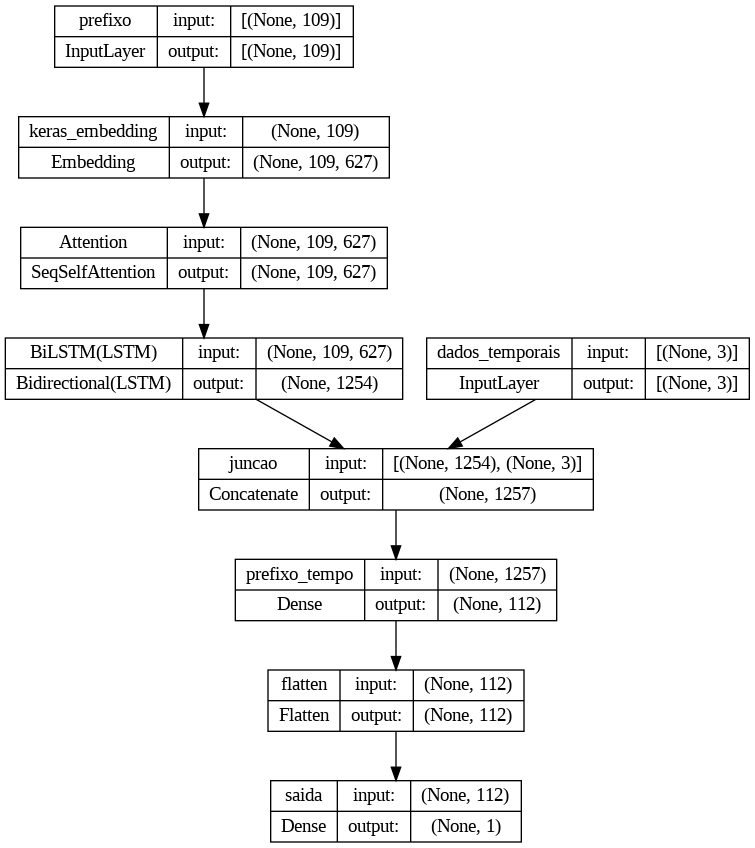

In [ ]:
seq_length = shape
seq_length_t = shape_t

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

att = SeqSelfAttention(
    attention_width=embedding_size,
    attention_activation='relu',
    name='Attention')(embedding)

rnn = Bidirectional(LSTM(embedding_size,
                            dropout=0.1,
                            recurrent_dropout=0.1,
                            kernel_regularizer=keras.regularizers.l2(0.01), name='LSTM'),
                       name='BiLSTM')(att)


x = concatenate([rnn, time_input], name='juncao')

x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Flatten()(x)
x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=10, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=150,
                    batch_size=1200,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

ResourceExhaustedError: ignored

Loss

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

In [ ]:
test_predicton.shape

In [ ]:
y_test.shape

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mae_error = mean_absolute_error(y_test, test_predicton)

In [ ]:
y_t = []

for t in y_test:
  cur_t = str(t)
  str_v = cur_t.replace('[','')
  str_v = str_v.replace(']','')
  y_t.append(float(str_v))

int_conf = ci(abs(y_t - np.squeeze(test_predicton)))

print('ci: ' , mae_error, int_conf)

CSV resultados pred x real

In [ ]:
#from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('A) SOL_INSC_BiLSTM_PRED_REAL.csv', index=False)

#files.download('A) SOL_INSC_BiLSTM_PRED_REAL.csv')

Avaliação por etapa

In [ ]:
MAX_STEP = df_test['Step'].max()

In [ ]:
MAX_STEP

In [ ]:
df_test['Step'].unique()

In [ ]:
df_full_test = pd.DataFrame(dl_x_test.reshape(dl_x_test.shape[0], (dl_x_test.shape[1]*dl_x_test.shape[2])))
df_full_test['Step'] = df_test['Step']
df_full_test['Time to conclusion'] = df_test['Time to conclusion']

In [ ]:
dl_full_t_test = pd.DataFrame(dl_x_t_test.reshape(dl_x_t_test.shape[0], (dl_x_t_test.shape[1]*dl_x_t_test.shape[2])))
dl_full_t_test['Step'] = df_test['Step']

In [ ]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  dl_x__local_test = df_full_test[df_full_test['Step'] == i]
  ACT_COLS = dl_x__local_test.columns.tolist()
  ACT_COLS.remove('Step')
  ACT_COLS.remove('Time to conclusion')
  x_local = dl_x__local_test[ACT_COLS].values

  dl_x_t_local_test = dl_full_t_test[dl_full_t_test['Step'] == i]
  TIME_COLS = dl_x_t_local_test.columns.tolist()
  TIME_COLS.remove('Step')
  x_t_local = dl_x__local_test[TIME_COLS].values

  print(dl_x_t_local_test.shape)

  y_local_test = df_full_test[df_full_test['Step'] == i]['Time to conclusion']
  local_test_predicton = model.predict([[x_local, x_t_local]])

  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

In [ ]:
for s, m in zip(step,mae):
  print(s,m)

In [ ]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

In [ ]:
np.mean(mae)